# Assignment 3: Cross Modal Search [190]

In this assignment, we'll introduce cross-modal search. We'll work with a dataset of images and their corresponding captions, where each image is associated with multiple descriptive captions. Our goal is to learn how to create contextual embeddings for different modalities (images and text) and build an efficient search mechanism that allows us to seamlessly navigate between these modalities. This will enable performing image-to-image, image-to-text, text-to-text, and text-to-image searches.

In [ ]:
# imports
!pip -q install datasets
!pip install transformers
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import warnings
import numpy as np
import torch
from tqdm import tqdm
import heapq
import time
import pprint
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union, Generator, Dict, Any
from PIL import Image
import requests
from transformers import ViTImageProcessor, ViTModel

warnings.filterwarnings("ignore")

## Dataset Loading and Exploration



Please download the dataset from the following link: [Dataset](https://drive.google.com/file/d/19KPsmsNhj6Q-W6yfYHud2K8EfPdWU2mc/view?usp=sharing).
Once downloaded, you can load and manage the data using the datasets library from Hugging Face.

In [3]:
# load the downloaded dataset from disk here
from datasets import load_from_disk

ds = load_from_disk("task_dataset")

After running this code, you should observe that the dataset contains 15,000 images, each associated with a list of captions. Familiarizing yourself with the dataset structure is essential for the embedding generation and search tasks.

In [4]:
# after loading the dataset, it will look like the follwoing
ds

Dataset({
    features: ['url', 'sentences'],
    num_rows: 15000
})

## Image Embedding Generation [10]

### EXPLANATION: Model choosing
Models were chosen to ensure they generate embeddings of the same size (768). This consistency is particularly beneficial for the last exercise.

After loading the dataset, the next step is to create meaningful representations of the images in a vector format – image embeddings. These embeddings will capture the semantic essence of the images and enable you to perform similarity comparisons. You have the freedom to choose any embedding method that suits your needs like CNN pretraiend methods or VITs, etc..., but consider its effectiveness for similarity search.
Ensure you embed all images in the dataset using the same chosen method to maintain a comparable embedding space.



---


**Important Note**: It is not allowed to use the same embedding method for image and text, they should be different methods but it's totally fine and recommended if the vector dimensions after embedding of text and image are the same size.

Below find two helper functions to streamline the image loading and embedding process.

In [ ]:
def load_image_from_url(url: str) -> np.ndarray:
    """Loads an image from a given URL and converts it to an RGB NumPy array.

    Args:
        url: The URL of the image to load.

    Returns:
        A NumPy array representing the image in RGB format.
    """
    img = Image.open(requests.get(url, stream=True).raw).convert('RGB') # download the image
    return np.array(img)

def encode_image(image: str) -> np.ndarray:
    """Encodes a given image URL into an embedding vector.

    Args:
        image:  The URL of the image to encode.

    Returns:
         A NumPy array representing the image embedding.
    """
    # download and preprocess the image
    img = Image.open(requests.get(image, stream=True).raw).convert('RGB') 
    inputs = processor(images=img, return_tensors="pt")

    # get embedding for the image
    with torch.no_grad():
        outputs = model_images(**inputs) 

    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return embedding

# model loading
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model_images = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

model_images.eval()
image_data = []

# creating embeddings
for idx, url in tqdm(enumerate(ds['url']), total=len(ds['url'])):
    image_data.append((idx, encode_image(url)))

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

## Text Embedding Generation [20]

Similar to what you did when you created embeddings for images, you now need to generate embeddings for the text captions. It's important to consider the multi-caption nature of the data, each image has multiple associated captions, and you should represent this effectively in the text embeddings. Similar to the choice made with image dimension size you should maintain consistency of text dimension embeddign, choosing a good way to embed all captions per image is important to achieve good results.

In [ ]:
def encode_text(captions: List[List[str]]) ->  List[np.ndarray]:
    """Encodes a list of captions (one list per image) into a list of text embeddings.

    Args:
      captions: A list of lists, where each inner list contains captions for a single image.

    Returns:
      A list of NumPy arrays, where each array represents embedding for an image's captions.
    """
    # get embeddingsfor the captions
    captions_embeddings = model_text.encode(captions) 
    return np.mean(captions_embeddings, axis=0) # take the average to get 1 embedding for captions for 1 image

# model loading
model_text = SentenceTransformer('all-mpnet-base-v2')
model_text.eval()
text_data = []

# creating embeddings
for idx, sentences in tqdm(enumerate(ds['sentences']), total=len(ds['sentences'])):
    text_data.append((idx, encode_text(sentences)))

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Efficient Similarity Search with KD-Trees [70]

One of the main way to implement KNN is based on KD-Tree. KD-Trees are particularly well-suited for nearest neighbor searches in high-dimensional spaces, making them perfect for finding similar images and text based on their embeddings. The KDTree class provided below enables building the tree and performing efficient queries. It allows you to add data in form of tuples, index for image number, caption number inside of images as first parameter and emebdding as second. It also supports euclidean and cosine distance metric based on provided distance type.

**_build_tree**:
This method recursively builds the KDTree. It selects a dimension based on recursion depth, sorts the points along that dimension, and divides the points into subtrees, creating a hierarchical tree structure

**_search_knn**:
This method performs a k-nearest neighbor search by exploring the tree. It keeps track of the closest points and ensures the most relevant candidates are found by searching both subtrees when needed..

**find_knn**:
This method returns the k-nearest neighbors to a target point. It calls the _search_knn method to gather the neighbors and then sorts and returns them, with an option to include their distances.

**nearest_neighbor**:
This method returns the nearest neighbor(s) to a given target point, using the find_knn method. It can return both the points and their distances or just the points, based on the include_distance flag, **this is the method to be used by the user to retireve nearset neighbors.**

__iter__:
This method allows iteration over all points in the KDTree, providing an easy way to loop through the tree’s points in a structured order.


In [103]:
class KDTree:
    """
    A KD-Tree implementation for efficient nearest neighbor search.
    """

    def __init__(self, points: List[Tuple[int, np.ndarray]], dimension: int, distance_type: str = 'euclidean') -> None:
        """
        Initializes a new KD-Tree and selects the distance metric.

        Args:
            points: A list of (index, embedding) tuples to build the tree from.
            dimension: The dimensionality of the embedding vectors.
            distance_type: The type of distance metric to use ('euclidean' or 'cosine'). Defaults to 'euclidean'.
        """
        self.dimension: int = dimension
        self.root: Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]] = None
 
        if distance_type == 'euclidean':
            # calculate euclidean distance
            self.distance_func = lambda a, b: np.linalg.norm(a - b)
        elif distance_type == 'cosine':
            # calculate cosine distance
            self.distance_func = lambda a, b: 1 - (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
        else:
           raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

        # build the tree
        self.root = self._build_tree(points)

    def _build_tree(self, points: List[Tuple[int, np.ndarray]], depth: int = 0) -> Optional[Dict[str, Union[Tuple[int, np.ndarray], Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]]]]]:
        """
        Recursively builds the KD-Tree from the input points.

        Args:
            points: The set of points to build the tree from.
            depth: The current depth of the recursion, used to determine which dimension to split along.

        Returns:
            A node in the tree structure, containing information about the point and its child nodes.
        """

        # base case for the recusrion regime
        if not points:
            return None

        # selecting the axis (dimension)
        axis = depth % self.dimension

        # sort point by chosen dimension of embedding
        sorted_points = sorted(points, key=lambda ind_emb: ind_emb[1][axis])

        # choose median point to divide the tree to 2 parts
        median_idx = len(sorted_points) // 2

        node = {}
        node['point'] = sorted_points[median_idx]
        node['left'] = self._build_tree(sorted_points[:median_idx], depth + 1)
        node['right'] = self._build_tree(sorted_points[median_idx + 1:], depth + 1)

        return node

    def insert(self, new_point: Tuple[int, np.ndarray]) -> None:
        """
        Inserts a new point into the KD-Tree.

        Args:
            new_point: A tuple (index, embedding) to be added to the Tree.
        """
        def _insert(node, point_to_insert, depth):
            # reached the leaf, insert point_to_insert and return the node 
            if node is None:
                return {
                'point': point_to_insert,
                'left': None,
                'right': None
            }

            # update the axis
            axis = depth % self.dimension

            # get embeddings
            point_to_insert_emb = point_to_insert[1]
            point_emb = node['point'][1]

            # choose part of tree to insert new point
            if point_to_insert_emb[axis] < point_emb[axis]:
                node['left'] = _insert(node['left'], point_to_insert, depth + 1)
            else:
                node['right'] = _insert(node['right'], point_to_insert, depth + 1)

            return node

        self.root = _insert(self.root, new_point, 0)

    def find_knn(self, target: np.ndarray, k: int, include_distances: bool = True) -> List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]:
        """
        Finds the k-nearest neighbors to a target point in the KD-Tree.

        Args:
            target: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distances: Whether to return distances between query and neighbors. Default is True.

        Returns:
            List of k-nearest neighbors and optionally distances to those neighbors.
        """
        # initialize array to store result
        max_heap = []

        # perform search for neighbors
        self._search_knn(self.root, target, k, max_heap)
        
        # sort the neighbors based on distance
        sorted_neighbors = sorted([(-elem[0], (elem[1][0], elem[1][1])) for elem in max_heap], key=lambda x: x[0])

        # compose the final result
        if include_distances:
            return sorted_neighbors
        else:
            return [n[1] for n in sorted_neighbors]

    def _search_knn(self, current_node: Optional[Dict[str, Any]],
                   target_point: np.ndarray, k: int,
                   max_heap: List[Tuple[float, Tuple[int, np.ndarray]]],
                   depth: int = 0) -> None:
        """
        Recursively searches the KD-Tree for the k-nearest neighbors.

        This method uses a max-heap to efficiently track the k closest points found so far.

        Args:
            current_node: The current node being visited (dictionary with 'point', 'left', 'right').
            target_point: The query point.
            k: The number of nearest neighbors to find.
            max_heap: A max-heap (using heapq) storing (-distance, (index, point)).
            depth: Recursion depth (used for splitting dimension).

        Hints:
            1. Calculate distance from target to the current node's point.
            2. Update the max-heap if necessary (add or replace based on distance).
            3. Recursively explore relevant subtrees.  Consider when you need to search both subtrees (closer and farther)
               to guarantee finding all k-nearest neighbors.
        """
        if current_node is None:
            return

        # get the current node and it's embedding
        point = current_node['point']
        point_emb = point[1]

        # calculate the distance between current point and target point
        dist = self.distance_func(target_point, point_emb)

        # decide whether to add current point to array of neighbors
        if len(max_heap) < k:
            heapq.heappush(max_heap, (-dist, point))
        elif -dist > max_heap[0][0]:
            heapq.heappushpop(max_heap, (-dist, point))

        # update the axis
        axis = depth % self.dimension

        # choose which part to explore first
        if target_point[axis] < point_emb[axis]:
            closer_node = current_node['left']
            farther_node = current_node['right']
        else:
            closer_node = current_node['right']
            farther_node = current_node['left']
        
        # preform the search
        self._search_knn(closer_node, target_point, k, max_heap, depth + 1)

        # decide whether to perform search from the farther node also
        if len(max_heap) < k or abs(target_point[axis] - point_emb[axis]) < -max_heap[0][0]:
            self._search_knn(farther_node, target_point, k, max_heap, depth + 1)

    def nearest_neighbor(self, target_point: np.ndarray, k: int = 5, include_distance: bool = True) -> Optional[List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]]: 
        """
        Finds the nearest neighbor to a target point by calling find_knn and returning the result up to k.

        Args:
            target: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distances: Whether to return distances. Default is True.

        Returns:
            Optional list of the nearest points and optionally distances.
        """
        return self.find_knn(target_point, k, include_distances=include_distance)

    def __iter__(self) -> Generator[Tuple[int, np.ndarray], None, None]:
        """
        Iterates through all stored embeddings with their indices.

        Returns:
            A generator yielding (index, embedding) tuples.
        """
        def traverse(node):
            if node is not None:
                yield from traverse(node['left'])
                yield node['point']
                yield from traverse(node['right'])
        return traverse(self.root)

    def range_query(self, target: Union[np.ndarray, Tuple[int, np.ndarray]], radius: float) -> List[int]:
        """
        Finds all points within a certain radius from the target point.

        Args:
            target_point: The query embedding.
            radius: The maximum allowable distance from the target point.

        Returns:
            A list of indcies within the radius.
        """
        # array to store the indices of the point within the radius
        results = []

        def _recursive_search(node, target_embedding, depth = 0):
            if node is None:
                return

            # upadte the axxis
            axis = depth % self.dimension

            # get point and it's embedding 
            point = node['point']
            point_emb = point[1]

            # calculate the distance between the target_embedding and the point_emb
            dist = self.distance_func(target_embedding, point_emb)

            # add the point to the result
            if dist <= radius:
                results.append(point[0])
            
            # decide whether to explore further
            if target_embedding[axis] - radius <= point_emb[axis]:
                _recursive_search(node['left'], target_embedding, depth + 1)
            if target_embedding[axis] + radius >= point_emb[axis]:
                _recursive_search(node['right'], target_embedding, depth + 1)
        
        # get the embedding of the target
        if isinstance(target, tuple):
            t_emb = target[1]
        else:
            t_emb = target

        # perform the recursive search
        _recursive_search(self.root, t_emb)
        return results

### Testing KD-Tree on Images Data

In [104]:
# load image 
test_point = 110
load_image_from_url(ds["url"][test_point])

array([[[ 81,  62,  55],
        [ 99,  90,  93],
        [ 90,  83,  75],
        ...,
        [131, 124, 116],
        [121, 135, 135],
        [ 92, 204, 216]],

       [[ 85,  74,  72],
        [ 94,  94,  86],
        [ 84,  84,  76],
        ...,
        [116, 116, 108],
        [119, 122, 131],
        [101, 178, 208]],

       [[ 91,  63,  75],
        [ 97,  83,  72],
        [100,  80,  79],
        ...,
        [115, 120, 114],
        [116, 129, 137],
        [ 79, 160, 190]],

       ...,

       [[ 40,  63,  69],
        [ 65,  78,  86],
        [ 90,  88,  99],
        ...,
        [ 65,  81, 106],
        [ 75,  87, 113],
        [ 77,  83, 119]],

       [[ 94,  71,  77],
        [ 88,  76,  78],
        [ 79,  79,  79],
        ...,
        [ 68,  90, 111],
        [ 70,  86, 109],
        [ 80,  84, 121]],

       [[ 83,  86,  91],
        [ 87,  88,  93],
        [ 96,  91,  97],
        ...,
        [ 71,  89, 111],
        [ 69,  74, 103],
        [ 82,  70, 116]]

In [109]:
start = time.time()
# build the tree
kdtree = KDTree(image_data, dimension=len(image_data[0][1]), distance_type='euclidean')
end_build = time.time()

# seache for NN
result = kdtree.nearest_neighbor(image_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.08243012428283691 seconds
Time to build the KDTree and Search: 0.1404719352722168 seconds


In [110]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else  [idx for idx, _ in result]
print("Nearset neighbors indices", indices)

Nearset neighbors indices [110, 9605, 12302, 10627, 2074, 13917]


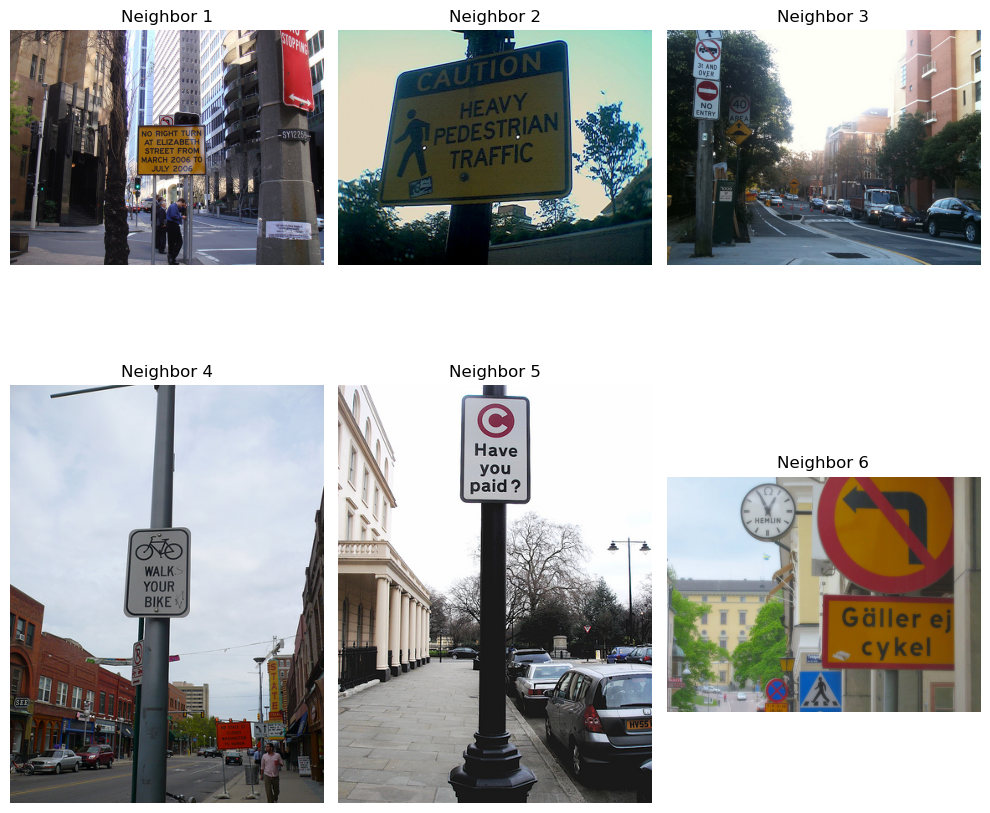

In [111]:
# print results
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(ds["url"][indices[i]])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing KD-Tree on Text Data

In [112]:
test_point = 110
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [113]:
start = time.time()
# Build kdtree on text data
kdtree = KDTree(text_data, dimension=len(text_data[0][1]), distance_type='euclidean')
end_build = time.time()

# Retrieve the nearest neighbors for a test point
result = kdtree.nearest_neighbor(text_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.17832207679748535 seconds
Time to build the KDTree and Search: 0.24320101737976074 seconds


In [114]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else  [idx for idx, _ in result]
print("Nearset neighbors indices", indices, "\n")

sentences_to_print = [ds["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

Nearset neighbors indices [110, 9278, 14920, 21, 7837, 13063] 

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'A two way street with a stay to the right sign.',
        'a street sign near a street light and trees',
        'A sign that is in the middle of the street.',
        'Signs line a tree paved street and sidewalks',
        'A street sign sitting in the middle of a center divider.'],
    [   'A street sign sitting next to a very tall building.',
        'This is a bunch of street signs on a city street.',
        'Intersection of a number of streets show from below. ',
        'A sign with some other signs on top of it ',
        'Several directional signs are set on a pole in a city street.'],

## Approximate K-Nearest Neighbors with Locality-Sensitive Hashing (LSH) [60]

One effective approach to building an Approximate K-Nearest Neighbor (AKNN) search is by using Locality-Sensitive Hashing (LSH). LSH is a technique that hashes data points in such a way that similar points are more likely to fall into the same hash "bucket." This allows to search a smaller subset of the data for approximate nearest neighbors, making the search process faster, particularly in high-dimensional spaces like embeddings.

Read here: [LSH Paper](https://www.cs.princeton.edu/courses/archive/spring13/cos598C/Gionis.pdf)

> **Note**: LSH operates by reducing dimensional complexity and comparison count, so expect approximate (not exact) results.

The `__init__` method initializes the Locality-Sensitive Hashing (LSH) structure. It prepares the data points, sets up the hash table, and decides which distance metric to use (Euclidean or Cosine).

It sets up the necessary structure for efficiently storing and accessing data points based on similarity, using hash keys generated from random hyperplanes.

---

### `_generate_hyperplanes` Method:
This method generates random hyperplanes used to hash data points into different categories.

It creates the foundation for grouping similar data points together by generating random decision boundaries that will be used to assign points to specific buckets.

---

### `_generate_hash_key` Method:
This method creates a unique identifier (hash key) for each data point based on how the point compares to the generated hyperplanes.

It transforms each data point into a simple identifier (binary key), which helps in quickly finding similar points later by grouping them in the same bucket.

---

### `_query_hash_candidates` Method:
This method looks up potential neighbors of a query point in the hash table by generating multiple hash keys for the query.

It increases the chances of finding similar points by querying the hash table multiple times, ensuring a broader pool of candidates for comparison.

---

### `_create_hash_table` Method:
This method builds a table that associates each data point’s hash key with the points that share the same key.

It organizes the data into buckets based on the hash key, making it easier and faster to find similar points later on.

---

### `approximate_knn_search` Method:
This method performs a quick search to find the nearest neighbors to a query point using the pre-built hash table.

Here’s how the entire pipeline works:

### 1. **Initialization:**
   - When the `LSH` class is initialized, the data points are passed in, and the algorithm sets up essential structures:
     - **Data Storage**: The data points are stored in an array.
     - **Hyperplanes**: Random hyperplanes are generated. These hyperplanes will be used to hash the data points.
     - **Hash Table**: A hash table is created to store data points based on their hash keys.
---

### 2. **Hashing the Data Points:**
   - Every data point is transformed into a unique hash key using the hyperplanes.
   - The method `_generate_hash_key` decide the position of the point with respect to the hyperplane and based on this, a binary string (hash) is created for each point, representing which side of each hyperplane the point lies on.

---

### 3. **Storing Data Points in Buckets:**
   - The hash keys generated for each data point are used to store the points in a hash table.
   - If two data points share the same hash key, they are placed in the same bucket.

---

### 4. **Querying for Nearest Neighbors:**
   - When you query for the nearest neighbors of a point, the algorithm process the query point in the same way as the data points and then
   check it for candidate data points that share the same hash key.

---

### 5. **Candidate Selection and Refinement:**
   - The set of candidate points retrieved from the hash table is not guaranteed to contain the exact nearest neighbors, but they are likely to be similar.
   - The algorithm can query the hash table multiple times (controlled by the `repeat` parameter) to increase the chance of retrieving all relevant candidates.
   - After all candidates are retrived the alog will use distance to refine the retrived points.
---

### Final Flow:
1. **Initialization**: Set up data, hyperplanes, and hash table.
2. **Hashing**: Generate hash keys for each data point and store them in the hash table.
3. **Querying**: For a given query point, generate its hash keys and retrieve candidate points from the hash table.
4. **Refinement and Return**: Calculate distances and Return the top `k` nearest neighbors.

In [200]:
class LSH:
    def __init__(self, index_data: np.ndarray, bucket_size: int = 16, seed: int = 0, distance_type: str = 'cosine'):
        """
        Initialize LSH with data, bucket size, random seed, and distance type.

        :param index_data: Array of tuples where each tuple consists of an index and data point.
        :param bucket_size: Number of data points per bucket.
        :param seed: Seed for random number generator.
        :param distance_type: Type of distance metric, either 'euclidean' or 'cosine'.
        """
        # extract information from index_data
        self.indices, self.data = zip(*index_data)
        self.data = np.asarray(self.data)

        # define and initialize important variables
        self.bucket_size = bucket_size
        self.rng = np.random.default_rng(seed)
        self.hyperplanes = self._generate_hyperplanes()
        self.hash_table = self._create_hash_table()

        # choose distance function
        if distance_type == 'euclidean':
            self.distance_func = self._euclidean_distance
        elif distance_type == 'cosine':
            self.distance_func = self._cosine_distance
        else:
            raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

    def _generate_hyperplanes(self) -> np.ndarray:
        """
        Generate random hyperplanes for hashing based on feature dimensions and bucket size.

        :return: Array of hyperplanes for hashing data.
        """
        # get the dimension of data embeddings
        feature_dim = self.data.shape[1]

        # calculate number of hyperplanes and generate them randomly
        num_hyperplanes = int(np.ceil(np.log2(len(self.data) // self.bucket_size)))
        return self.rng.normal(size=(num_hyperplanes, feature_dim))

    def _generate_hash_key(self, points: np.ndarray) -> np.ndarray:
        """
        Generate a hash key for given points based on the hyperplanes
        Remember that you need to convert the resulting binary hash into a decimal value.

        :param points: Array of data points to hash.
        :return: Hash keys for the data points.
        """
        # define hash key for each embedding based on its location with respect to the hyperplanes
        projections = np.dot(points, self.hyperplanes.T)
        projections_to_binary = (projections >= 0).astype(int)
        powers_of_two = 2 ** np.arange(projections_to_binary.shape[1])[::-1]
        hash_keys = projections_to_binary.dot(powers_of_two)
        return hash_keys

    def _query_hash_candidates(self, query: np.ndarray, repeat: int = 10) -> List[int]:
        """
        Retrieve candidates from hash table based on query and specified repeat count.

        :param query: Query data point.
        :param repeat: Number of times to hash the query for candidate retrieval.
        :return: List of candidate indices.
        """
        candidates = set()

        # for _ in range(repeat):
        #     # generate hash key for query and get candidate indices
        #     hash_key = self._generate_hash_key(query.reshape(1, -1))[0]  
        #     if hash_key in self.hash_table:
        #         candidates.update(self.hash_table[hash_key])

        # generate hash key for query and get candidate indices
        hash_key = self._generate_hash_key(query.reshape(1, -1))[0]  
        if hash_key in self.hash_table:
            candidates.update(self.hash_table[hash_key])
        return list(candidates)

    def _euclidean_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        """
        Compute Euclidean distance between points and query.

        :param points: Array of points to compare.
        :param query: Query point.
        :return: Array of distances.
        """
        return np.linalg.norm(points - query, axis=1)

    def _cosine_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        """
        Compute Cosine distance between points and query.

        :param points: Array of points to compare.
        :param query: Query point.
        :return: Array of cosine distances.
        """
        return 1 - np.dot(points / np.linalg.norm(points, axis=1, keepdims=True), query / np.linalg.norm(query))

    def _create_hash_table(self) -> dict:
        """
        Create a hash table for the LSH algorithm by mapping data points to hash buckets.

        :return: Hash table with keys as hash values and values as lists of data indices.
        """
        # initialize hash table
        hash_table = {}

        # get hash keys for data
        hash_keys = self._generate_hash_key(self.data)

        # iterate through all data points
        for idx, key in zip(self.indices, hash_keys):
            # add data points to hash table
            if key not in hash_table:
                hash_table[key] = []
            hash_table[key].append(idx)
            
        return hash_table

    def approximate_knn_search(self, query: np.ndarray, k: int = 5, repeat: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform approximate K-nearest neighbor search on the query point.

        :param query: Query point for which nearest neighbors are sought.
        :param k: Number of neighbors to retrieve.
        :param repeat: Number of times to hash the query to increase candidate count.
        :return: Tuple of nearest points, their distances, and their original indices.
        """
        candidates_indices = self._query_hash_candidates(query, repeat = repeat)
        if not candidates_indices:
            return np.array([]), np.array([]), np.array([]) # Return empty arrays for all
        
        # get candidates indices (indices of embeddings) and their corresponding distances
        candidates = self.data[candidates_indices]
        distances = self.distance_func(candidates, query)

        # get closest candidates
        nearest_k_indices_in_distances = np.argsort(distances)[:k]
        
        # get indices of closest candidates
        candidate_points_np = np.array(candidates_indices)
        nearest_points_original_indices = candidate_points_np[nearest_k_indices_in_distances]

        # finalise and return results
        return candidates[nearest_k_indices_in_distances], distances[nearest_k_indices_in_distances], nearest_points_original_indices

### Testing LSH on Images Data

In [201]:
test_point = 110
load_image_from_url(ds["url"][test_point])

array([[[ 81,  62,  55],
        [ 99,  90,  93],
        [ 90,  83,  75],
        ...,
        [131, 124, 116],
        [121, 135, 135],
        [ 92, 204, 216]],

       [[ 85,  74,  72],
        [ 94,  94,  86],
        [ 84,  84,  76],
        ...,
        [116, 116, 108],
        [119, 122, 131],
        [101, 178, 208]],

       [[ 91,  63,  75],
        [ 97,  83,  72],
        [100,  80,  79],
        ...,
        [115, 120, 114],
        [116, 129, 137],
        [ 79, 160, 190]],

       ...,

       [[ 40,  63,  69],
        [ 65,  78,  86],
        [ 90,  88,  99],
        ...,
        [ 65,  81, 106],
        [ 75,  87, 113],
        [ 77,  83, 119]],

       [[ 94,  71,  77],
        [ 88,  76,  78],
        [ 79,  79,  79],
        ...,
        [ 68,  90, 111],
        [ 70,  86, 109],
        [ 80,  84, 121]],

       [[ 83,  86,  91],
        [ 87,  88,  93],
        [ 96,  91,  97],
        ...,
        [ 71,  89, 111],
        [ 69,  74, 103],
        [ 82,  70, 116]]

In [202]:
start = time.time()
lsh = LSH(image_data, seed=42)
result = lsh.approximate_knn_search(image_data[test_point][1], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.056596994400024414 seconds

Nearest neighbors indices [  110 13820  6452 11107  6189  3818]


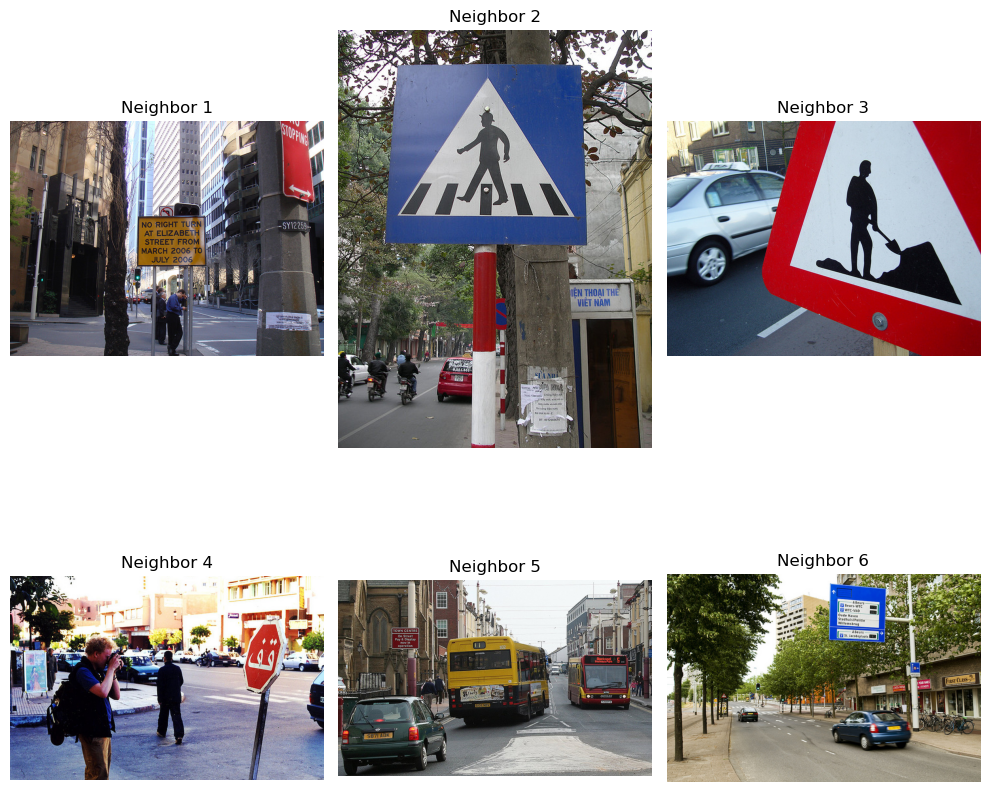

In [203]:
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(ds["url"][indices[i]])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing LSH on Text Data

In [207]:
start = time.time()
lsh = LSH(text_data, seed=42)
result = lsh.approximate_knn_search(text_data[test_point][1], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.07416105270385742 seconds

Nearest neighbors indices [  110  9278 14893  1208  8023 13820]


In [208]:
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [209]:
sentences_to_print = [ds["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'A two way street with a stay to the right sign.',
        'a street sign near a street light and trees',
        'A sign that is in the middle of the street.',
        'Signs line a tree paved street and sidewalks',
        'A street sign sitting in the middle of a center divider.'],
    [   'A city street with stop lights and street signs',
        'A traffic sign next to a street sign at a cross walk.',
        'A bunch of signs and lights on a city pole\n',
        'A shot of various street signs and traffic lights at a street corner.',
        'a street sign and a traffic light on a pole'],
    [   'A street sign that reads, "East 34th St" and "Fifth Av

## Cross-Modal Retrieval: Text-to-Image and Image-to-Text Search [30]

Now that you've implemented **image-to-image** and **text-to-text** search, it’s time to expand your capabilities to **cross-modal retrieval**. Cross-modal retrieval allows you to retrieve images when given a text query and vice versa. This section aims to achieve four types of retrieval:

- **Text-to-Text**
- **Image-to-Image**
- **Text-to-Image**
- **Image-to-Text**

**Challenge**: Unlike within-modal searches, cross-modal search involves different embedding spaces—image embeddings and text embeddings—which may not directly correlate with each other. You’ll need to identify a way to align or project both embedding spaces into a common or comparable space.

---

### Suggested Approaches

To achieve cross-modal retrieval, you may consider using one or more of the following methods or any method you want to bring both modalities into alignment:

1. **Canonical Correlation Analysis (CCA)**:
   - CCA is a statistical method designed to find correlations between two sets of variables. It’s often used to project paired data (such as images and their corresponding captions) into a shared space that maximizes correlation.

2. **Multimodal Projection Learning**:
   - Here, you can use supervised or semi-supervised techniques to map both image and text embeddings into a shared subspace. The idea is to minimize the distance between embeddings from each modality that are associated with the same concept (e.g., an image of a “dog” and the caption “a dog playing in the park”).

3. **Partial Least Squares (PLS) Regression**:
   - PLS regression can help project both image and text embeddings into a common latent space, maximizing the covariance between them. This is similar to CCA but it works better for high-dimensional data.

4. **Joint Embedding Optimization**:
   - In this approach, you can train or adjust both text and image embeddings such that paired data points (e.g., an image and its caption) are closer to each other, while non-paired points are farther apart.

5. **Sparse Coding**:
   - This method involves representing both image and text embeddings as sparse codes in a common dictionary space. You can then compute similarities between these sparse representations.

---

### Task Instructions

1. **Method Selection**:
   - Choose an alignment or projection method for cross-modal retrieval from the options above, or research another approach you think might work well.
   - Implement the chosen approach, allowing for text-to-image and image-to-text queries.

2. **Testing and Observations**:
   - Run test queries for **text-to-image**, **image-to-text**, **text-to-text** and **image-to-image** search using your approach.
   - Record your observations:
     - Did the retrieved items was correct?
     - How well does the method capture relationships between the modalities?
     
3. **Code and Results**:
   - Provide the code for your method implementation with results for several test queries.


Below are examples of one solution I created to do searches from text to text, text to image, image to text and image to image.

Imagine we have built KDTree based on text embedding, we insert image query embedding in this tree and search for NN text and when we build KDTree based on images embedding, we insert text query to this tree and search for NN images.

### Canonical Correlation Analysis (CCA)

### EXPLANATION: 
CCA is ideal for cross-modal retrieval because it aligns different embedding spaces, such as image and text embeddings, by maximizing the correlation between them in a shared subspace. This ensures that semantically related image-text pairs have the highest linear correlation. In my implementation, I scaled both image and text embeddings using `StandardScaler`, then applied CCA with a specified number of components to project them into a common space. By transforming the embeddings with CCA, I was able to build KD-Trees on the new embeddings and perform effective text-to-image and image-to-text searches.

#### Implementation

In [210]:
from sklearn.cross_decomposition import CCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [ ]:
# extract embeddings
image_embeddings = np.array([embedding for _, embedding in image_data])  
text_embeddings = np.array([embedding for _, embedding in text_data]) 

# define scalers
scaler_image_embeddings = StandardScaler()
scaler_text_embeddings = StandardScaler()

# scale embeddings
image_embeddings_scaled = scaler_image_embeddings.fit_transform(image_embeddings)
text_embeddings_scaled = scaler_text_embeddings.fit_transform(text_embeddings)

# fit CCA (around 20 minutes)
n_components = 100
cca = CCA(n_components=n_components) 
cca.fit(image_embeddings_scaled, text_embeddings_scaled)

# transform embeddings by using CCA
new_image_embeddings, new_text_embeddings = cca.transform(image_embeddings_scaled, text_embeddings_scaled)

In [212]:
# build kd-trees for searching
new_text_data = [(i, emb) for i, emb in enumerate(new_text_embeddings)]
kdtree_new_text_embeddings = KDTree(new_text_data, dimension=len(new_text_data[0][1]), distance_type='euclidean')

new_image_data = [(i, emb) for i, emb in enumerate(new_image_embeddings)]
kdtree_new_image_embeddings = KDTree(new_image_data, dimension=len(new_image_data[0][1]), distance_type='euclidean')

In [213]:
# functions for cross modal search
def text_to_text(text_query_embedding: np.ndarray, k: int = 5):
    result = kdtree_new_text_embeddings.nearest_neighbor(text_query_embedding, k=k, include_distance=False)
    top_k_indices = [i for i, _ in result]
    return top_k_indices

def image_to_image(image_query_embedding: np.ndarray, k: int = 5):
    result = kdtree_new_image_embeddings.nearest_neighbor(image_query_embedding, k=k, include_distance=False)
    top_k_indices = [i for i, _ in result]
    return top_k_indices

def text_to_image(text_query_embedding: np.ndarray, k: int = 5):
    result = kdtree_new_image_embeddings.nearest_neighbor(text_query_embedding, k=k, include_distance=False)
    top_k_indices = [i for i, _ in result]
    return top_k_indices

def image_to_text(image_query_embedding: np.ndarray, k: int = 5):
    result = kdtree_new_text_embeddings.nearest_neighbor(image_query_embedding, k=k, include_distance=False)
    top_k_indices = [i for i, _ in result]
    return top_k_indices

# functions for getting transformed embeddings for quesry
def project_image(image_embedding):
    image_scaled = scaler_image_embeddings.transform(image_embedding.reshape(1, -1))
    image_cca = image_scaled @ cca.x_weights_ 
    return image_cca.flatten()

def project_text(text_embedding):
    text_scaled = scaler_text_embeddings.transform(text_embedding.reshape(1, -1))
    text_cca = text_scaled @ cca.y_weights_ 
    return text_cca.flatten()



### Text-to-Text

In [220]:
# text query, this text is not in the dataset, here we are doing text to text
text = "traffic light"

text_query_embedding = encode_text([text])
new_text_query_embedding = project_text(text_query_embedding)

top_10_indices = text_to_text(new_text_query_embedding, k=10)

# Print retrived top similar NN in text data
print("Indices of top 10 smallest distances:", top_10_indices)

for i in top_10_indices:
  for j in ds['sentences'][i]:
    print(j)
  print("===========")

Indices of top 10 smallest distances: [3110, 4252, 6256, 4675, 7639, 8428, 9703, 4408, 10554, 5596]
A traffic light hanging from the side of a pole.
A traffic light has turned yellow and do not walk sign is up.
A traffic light with the yellow light and the don't walk light lit up.
A traffic signal and a pedestrian crossing signal.
A traffic light signaling yellow, with a pedestrian light below.  
a light that is attached to a pole
A red traffic light sitting next to a street sign.
A stop light with a street sign next to it.
A traffic light and a street sign are mounted to a pole.
A traffic signal is pictured against a blue sky.
A couple of street lights are hanging up over a street
A side view of two traffic signals on a pole.
A stoplight on a pole with a blue sky
Two electronic traffic signals are below a street light.
A pole has two street lights on it for drivers.
A TRAFFIC LIGHT INDICATING A GREEN SIGNAL LIGHT
a stop light with the green light lit
The traffic light is visible for a

### Text-to-Image

In [221]:
# having the same query with the same embedding of this text, here we are searhcing for similar images of this text
top_10_indices = text_to_image(new_text_query_embedding, k=10)
print("Indices of top 10 smallest distances:", top_10_indices)

Indices of top 10 smallest distances: [8428, 312, 4719, 3957, 10430, 7093, 13678, 4295, 5253, 14229]


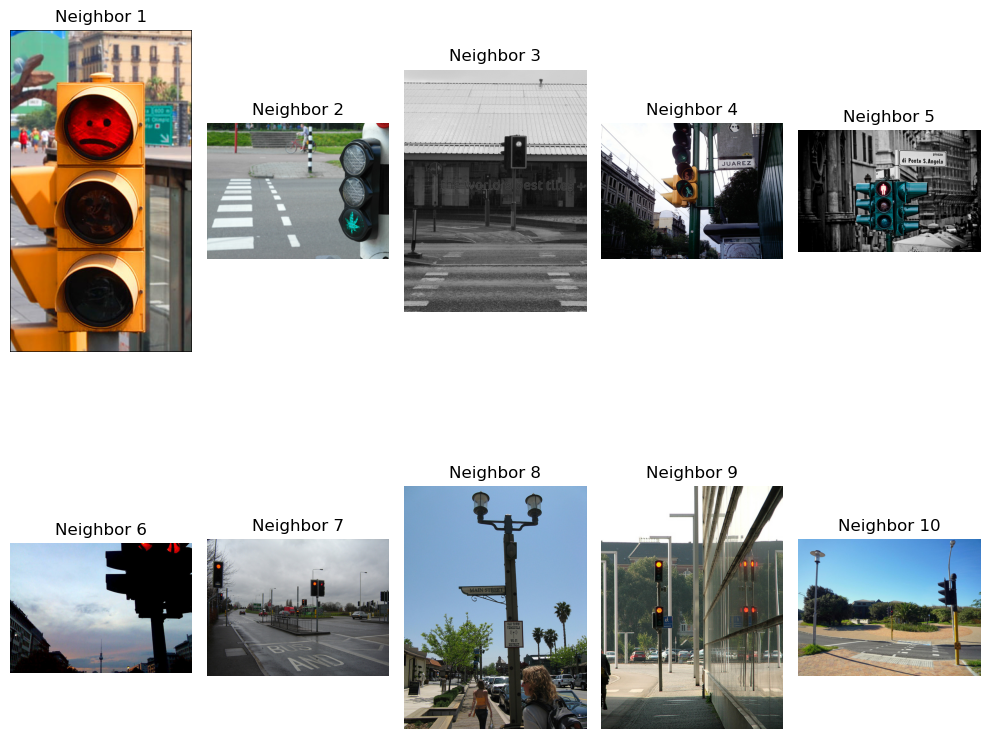

In [222]:
# Print retrieved NN images
retrieved_image_urls = [ds["url"][i] for i in top_10_indices]
num_neighbors = len(retrieved_image_urls)

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(retrieved_image_urls[i])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Image-to-Text

In [223]:
# selecting some random image from the dataset
image_query_url = ds[14700]["url"]
load_image_from_url(image_query_url)

array([[[ 28,  31,  12],
        [ 32,  27,  50],
        [ 37,  11,  20],
        ...,
        [250, 220, 106],
        [242, 212, 116],
        [245, 216, 116]],

       [[ 32,  48,   0],
        [ 45,  41,   6],
        [ 55,  14,  18],
        ...,
        [250, 213, 133],
        [246, 207, 148],
        [251, 216, 114]],

       [[ 46,  30,  31],
        [ 33,  29,   2],
        [ 19,  33,   0],
        ...,
        [248, 213, 109],
        [248, 215, 112],
        [251, 220,  52]],

       ...,

       [[140, 116,  70],
        [154, 123,   7],
        [143, 129,   0],
        ...,
        [  8,   9,   3],
        [ 10,   9,  17],
        [  0,   0,   0]],

       [[133, 118,  77],
        [137, 121,  43],
        [139, 124,  31],
        ...,
        [ 13,  14,   6],
        [  7,   6,  14],
        [  5,   5,   5]],

       [[140, 108,  83],
        [125, 107,  57],
        [133, 107,  46],
        ...,
        [ 14,  15,   7],
        [  2,   1,   9],
        [ 11,  11,  13]]

In [224]:
image_query_embedding = encode_image(image_query_url)  # Function to encode the image into an embedding
new_image_query_embedding = project_image(image_query_embedding) # projecting into new embedding space
top_10_indices = image_to_text(new_image_query_embedding, k=10) # getting NN for query

In [225]:
# now having our image, we are now doing image to text and below is the closest 10 text to this image
print("Indices of top 10 smallest distances:", top_10_indices)

Indices of top 10 smallest distances: [5626, 13540, 5645, 3422, 1513, 1167, 9934, 8746, 10269, 9382]


In [226]:
# Print retrieved NN images
for i in top_10_indices:
  for j in ds[i]["sentences"]:
    print(j)
  print("===========")

A living room with a large couch and a couple of windows.
a living room having a chair some rugs and a bed 
There are couches and chairs in the room.
There is a desk and chair in the bedroom.
A large room has a bed at the end of it.
a bed sitting in a bedroom next to a large wall.
a room with a bed , a sofa and two nightstands.
Well made bed in tiled room with blue sitting area.
a close up of a neatly made bedroom
A bedroom containing a couch next to a window with blue curtains and a bed cover in white sheets. 
A living room filled with furniture and large window.
A bedroom that is filled with different types of furniture. 
A room with a television and a bed.
A four poster bed with few furniture in a bedroom. 
A bedroom is well-furnished with a four-post bed, sitting chairs, a desk and a coffee table. 
A double bed hotel room with the entrance door leading into the sleeping area.
a bed room with two beds a tv and a table
A hotel room filled with two beds in front of a flat screen TV.
A

### Image-to-Image

In [227]:
# Now we are doing image to image, below is the top 10 closest images to our images
top_10_indices = image_to_image(new_image_query_embedding, k=10)

print("Indices of top 10 smallest distances:", top_10_indices)

Indices of top 10 smallest distances: [14700, 683, 3422, 6019, 14636, 6961, 3580, 8787, 8876, 3902]


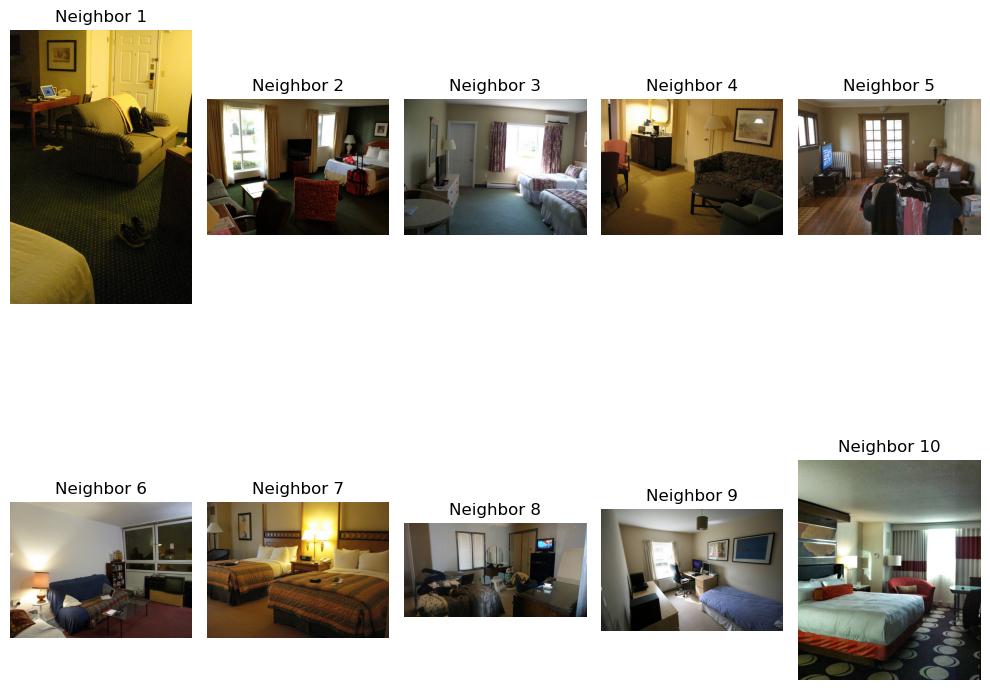

In [228]:
# Print retrieved NN images
retrieved_image_urls = [ds["url"][i] for i in top_10_indices]
num_neighbors = len(retrieved_image_urls)

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(retrieved_image_urls[i])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

# Resources used
- https://huggingface.co/docs/datasets/index
- https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python
- https://huggingface.co/google/vit-base-patch16-224-in21k
- https://huggingface.co/sentence-transformers/all-mpnet-base-v2
- https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
- https://www.baeldung.com/cs/k-d-trees
- https://www.geeksforgeeks.org/search-and-insertion-in-k-dimensional-tree/
- https://www.cs.princeton.edu/courses/archive/spring13/cos598C/Gionis.pdf
- https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/
- https://medium.com/@sarthakjoshi_9398/understanding-locality-sensitive-hashing-lsh-a-powerful-technique-for-similarity-search-a95b090bdc4a
- https://ru.stackoverflow.com/questions/1358274/%D0%9F%D0%BE%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-%D1%82%D0%BE%D1%87%D0%BA%D0%B8-%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE-%D0%BF%D0%BB%D0%BE%D1%81%D0%BA%D0%BE%D1%81%D1%82%D0%B8
- https://www.youtube.com/watch?v=e_SBq3s20M8
- https://numpy.org/doc/stable/reference/generated/numpy.packbits.html
- https://numpy.org/doc/stable/reference/random/generator.html
- https://scikit-learn.org/0.16/modules/generated/sklearn.cross_decomposition.CCA.html
